In [1]:
import datetime

import geopandas as gpd
import pandas as pd
import yaml
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
PATH_PROJECT = "/home/yoshraf/projects/mestrado/"

pd.options.display.max_columns = None

df07 = pd.read_parquet(f"{PATH_PROJECT}data/processed/dataset07.parquet")
df17 = pd.read_parquet(f"{PATH_PROJECT}data/processed/dataset17.parquet")

In [4]:
def subway_rate(df, od07=False):
    if od07:
        df = df[df["loc_domicilio_dist_metro"] >= 1000]
        df["loc_domicilio_dist_metro"] = df["loc_domicilio_dist_metro17"].values
    df = df[COLS]
    # Dropnan (viagens não realizadas)
    df = df.dropna()
    # Retira pessoas que ja moravam perto do metrô
    # Map de metro para
    df[LABEL] = df[LABEL].apply(lambda x: 1 if x == "Metrô" else 0)

    # Group by person
    df_mean = pd.DataFrame(df.groupby(IDX)[LABEL].mean())
    df_mean.columns = ["Taxa de Metrô"]
    df2 = df.merge(df_mean, on=IDX)
    df2 = df2.drop(columns=[LABEL]).drop_duplicates()
    return df2

In [30]:
def how_far(df, od07=False):
    if od07:
        df = df[df["loc_domicilio_dist_metro"] >= 1000]
        df["loc_domicilio_dist_metro"] = df["loc_domicilio_dist_metro17"].values
    df = df[COLS]
    # Dropnan (viagens não realizadas)
    df = df[df[LABEL] != 0]
    df = df.dropna()
    # Group by person
    df_sum = pd.DataFrame(df.groupby(IDX)[LABEL].sum())
    df_sum.columns = ["sum_dist_od"]
    df2 = df.merge(df_sum, on=IDX)
    df2 = df2.drop(columns=[LABEL]).drop_duplicates()
    return df2

In [31]:
df17.head()

,Zona de domicílio,Município do domicílio,Coordenada X domicílio,Coordenada Y domicílio,Identifica domicílo,Data da entrevista,Tipo de domicílio,Possui água encanada?,A rua é pavimentada?,Total de famílias no domicílio,Total de moradores na família,Condição de moradia,Quantidade de banheiros,Quantidade de empregados domésticos,Quantidade de automóveis,Quantidade de motocicletas,Quantidade de bicicletas,Critério de Classificação Econônica Brasil,Pontos Critério Brasil,Renda familiar mensal,Identifica Pessoa,Situação familiar,Idade,Gênero,Estuda atualmente?,Grau de instrução,Condição de atividade,Valor da renda individual,Número da viagem,Dia da Semana,Total de Viagens internas,Coordenada X Origem,Coordenada Y Origem,Coordenada X Destino,Coordenada Y Destino,Motivo na Origem,Motivo no Destino,Servir passageiro na Origem,Servir passageiro no Destino,Modo 1,Modo 2,Modo 3,Modo 4,Hora Saída,Minuto Saída,Tempo Andando na Origem,Hora Chegada,Minuto Chegada,Tempo Andando no Destino,Duração da Viagem (em minutos),Modo Principal,Número de ordem do registro,loc_domicilio,loc_origem,loc_destino,per Quantidade Automóvel,per Quantidade de motocicletas,per Quantidade de bicicletas,per Renda Familiar Mensal,loc_domicilio_dist_metro,loc_origem_dist_metro,loc_destino_dist_metro,dist_od
17471,46.0,São Paulo,340279.0,7392472.0,00460001,07032018,particular,Sim,Sim,1.0,2.0,Própria,1.0,0.0,1.0,0.0,0.0,B2,29.0,5500.0,00460001101,Pessoa responsável,75.0,Masculino,Não,Médio Completo/ Superior Incompleto,Aposentado/ Pensionista,4000.0,NaN,None,0.0,100.0,100.0,100.0,100.0,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,17472.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\xdc\xc4...,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00...,0.5,0.0,0.0,2750.0,1320.815456,7.389238e+06,7.389238e+06,0.000000
17472,46.0,São Paulo,340279.0,7392472.0,00460001,07032018,particular,Sim,Sim,1.0,2.0,Própria,1.0,0.0,1.0,0.0,0.0,B2,29.0,5500.0,00460001102,Conjugê/ companheiro(a),72.0,Feminino,Não,Médio Completo/ Superior Incompleto,Aposentado/ Pensionista,1500.0,NaN,None,0.0,100.0,100.0,100.0,100.0,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,17473.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\xdc\xc4...,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00...,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00...,0.5,0.0,0.0,2750.0,1320.815456,7.389238e+06,7.389238e+06,0.000000
17473,46.0,São Paulo,340773.0,7392059.0,00460003,27022018,particular,Sim,Sim,1.0,1.0,Própria,1.0,0.0,0.0,0.0,0.0,D - E,13.0,900.0,00460003101,Pessoa responsável,64.0,Masculino,Não,Fundamental II Completo/ Médio Incompleto,Tem Trabalho Regular,900.0,1.0,Segunda-feira,2.0,340773.0,7392059.0,340565.0,7392141.0,Residência,Trabalho Comércio,Não,Não,A pé,None,None,None,11.0,0.0,NaN,11.0,10.0,NaN,10.0,A pé,17474.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x94\xcc...,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x94\xcc...,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00T\xc9\x1...,0.0,0.0,0.0,900.0,858.990326,8.589903e+02,9.384249e+02,223.579963
17474,46.0,São Paulo,340773.0,7392059.0,00460003,27022018,particular,Sim,Sim,1.0,1.0,Própria,1.0,0.0,0.0,0.0,0.0,D - E,13.0,900.0,00460003101,Pessoa responsável,64.0,Masculino,Não,Fundamental II Completo/ Médio Incompleto,Tem Trabalho Regular,900.0,2.0,Segunda-feira,2.0,340565.0,7392141.0,340773.0,7392059.0,Trabalho Comércio,Residência,Não,Não,A pé,None,None,None,11.0,20.0,NaN,11.0,30.0,NaN,10.0,A pé,17475.0,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x94\xcc...,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00T\xc9\x1...,b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x94\xcc...,0.0,0.0,0.0,900.0,858.990326,9.384249e+02,8.589903e+02,223.579963
17475,46.0,São Paulo,340773.0,7392059.0,00460004,24022018,particular,Sim,Sim,1.0,5.0,Própria,2.0,0.0,0.0,0.0,0.0,C1,28.0,2400.0,00460004101,Pessoa responsável,41.0,Feminino,Não,Médio Completo/ Superior Incompleto,Tem Trabalho Regular,1100.0,1.0,Sexta-feira,4.0,340773.0,7392059.0,335581.0,739234

In [32]:
IDX = [
    "Identifica Pessoa"
]

COLS = [
    "Identifica Pessoa",
    "Idade",
    "Gênero",
    "per Quantidade Automóvel",
    "per Renda Familiar Mensal",
    "loc_domicilio_dist_metro",
    "Total de Viagens internas",
    "dist_od",
]

LABEL = "dist_od"

cols_rename = {
    "Identifica pessoa": "Identifica Pessoa",
    "per Renda familiar mensal": "per Renda Familiar Mensal",
    "per Quantidade de automóveis": "per Quantidade Automóvel",
    "Total de viagens da pessoa": "Total de Viagens internas"
}
df17.rename(columns = cols_rename, inplace=True)

In [33]:
df07_far = how_far(df07, od07 = True)
df17_far = how_far(df17)

<ipython-input-30-fe2898006e80>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["loc_domicilio_dist_metro"] = df["loc_domicilio_dist_metro17"].values


In [34]:
df07_far["OD17"] = 0
df17_far["OD17"] = 1

In [35]:
dataset = pd.concat([df07_far, df17_far])

In [37]:
dataset["T_600"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 600 else 0)
dataset["T_800"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 800 else 0)
dataset["T_1000"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 1000 else 0)

In [38]:
dataset = dataset.set_index(IDX)
dataset = pd.get_dummies(dataset, drop_first=True)

In [49]:
T = "T_800"
COLS_MODELING = ["Idade", "per Quantidade Automóvel", "per Renda Familiar Mensal", "OD17", T, "Gênero_Masculino"]
df_model = dataset[COLS_MODELING].copy()
df_model["OD17:T"] = df_model["OD17"].values * df_model[T].values
df_model = sm.add_constant(df_model)

In [50]:
res = sm.OLS(dataset["sum_dist_od"].values, df_model).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     33.89
Date:                Tue, 13 Jul 2021   Prob (F-statistic):           8.53e-47
Time:                        22:10:26   Log-Likelihood:                -79440.
No. Observations:                7368   AIC:                         1.589e+05
Df Residuals:                    7360   BIC:                         1.590e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [51]:
df_plot = pd.DataFrame(dataset.groupby(["OD17", T])["sum_dist_od"].mean()).reset_index()

In [52]:
df_plot

,OD17,T_800,sum_dist_od
0,0,0,11684.080077
1,0,1,12597.837389
2,1,0,11238.219733
3,1,1,10442.961315


<AxesSubplot:xlabel='OD17', ylabel='sum_dist_od'>

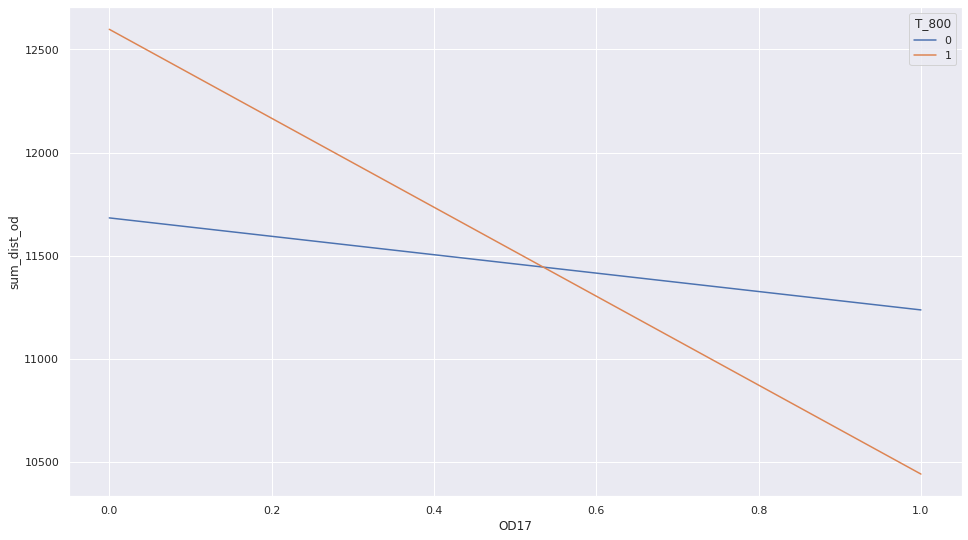

In [53]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df_plot, x="OD17", y="sum_dist_od", hue=T)

In [142]:
# Read config
with open(f"{PATH_PROJECT}{PATH_R_CONF}{YML}", encoding="utf8") as f:
    config = yaml.load(f, Loader=yaml.FullLoader, )

# Main variables
cols = config["DATAPREP"]["FLS6641-DISCRETE-CHOICE"]["SELECT_COLUMNS"]
idx = config["DATAPREP"]["FLS6641-DISCRETE-CHOICE"]["IDX"]
mapping = config["DATAPREP"]["FLS6641-DISCRETE-CHOICE"]["ENCODING"]
cat = config["DATAPREP"]["FLS6641-DISCRETE-CHOICE"]["CATEGORICAL"]
label = config["DATAPREP"]["FLS6641-DISCRETE-CHOICE"]["LABEL"]["COLUMN"]
label_values = config["DATAPREP"]["FLS6641-DISCRETE-CHOICE"]["LABEL"]

# Filter, select and Drop Values
dataset = df[cols + [label]].drop_duplicates()

# Filling missing valuies with mean
dataset.fillna(dataset.mean(), inplace=True)
# Mapping
for k, v in mapping.items():
    dataset[k] = dataset[k].map(v)
# Main Mode
dataset = dataset[~ dataset[label].isna()]
dataset[label] = dataset[label].apply(lambda x: 1 if x == "Metrô" else 0)
# Group by person
df_mean = pd.DataFrame(dataset.groupby(["Identifica pessoa"])[label].mean())
df_mean.columns = ["Taxa de Metrô"]
dataset2 = dataset.merge(df_mean, on=["Identifica pessoa"])
dataset2 = dataset2.drop(columns=[label]).drop_duplicates()
# Convert to Datetime
dataset2["Data da entrevista"] = pd.to_datetime(
    dataset2["Data da entrevista"], format="%d%m%Y").values
# GeoJoin
gdf = gpd.GeoDataFrame(dataset2,
                       geometry=gpd.points_from_xy(dataset2["Coordenada X domicílio"],
                                                   dataset2["Coordenada Y domicílio"]))
gdf.head(5)
gdf_neigh = gpd.read_file(
    "/home/yoshraf/projects/mestrado/data/gis/od2017/Distritos_2017_region.shp")
dist = ['Campo Belo', "Santo Amaro", "Itaim Bibi"]
gdf_neigh = gdf_neigh[gdf_neigh["NomeDistri"].isin(dist)]
gdf_f = gpd.sjoin(gdf, gdf_neigh, how="inner", op='intersects')

# --------------------------
# Plot to check our filters
gdf_metro = gpd.read_file(
    f"{PATH_PROJECT}data/gis/metro/SAD69-96_SHP_estacaometro_point.shp")
lst_metro_in = [
    "ALTO DA BOA VISTA",
    "BORBA GATO",
    "BROOKLIN"
]
gdf_metro_f = gdf_metro[gdf_metro["emt_nome"].isin(lst_metro_in)]
gdf_f[f"dist_metro_key"] = gdf_f["geometry"].apply(
    lambda x: gdf_metro_f.distance(x)).min(1)
# Create dist lower than 600, 800, 1000
gdf_f["dist_metro_menor_600"] = gdf_f["dist_metro_key"].apply(lambda x: 1 if x < 600 else 0)
gdf_f["dist_metro_menor_800"] = gdf_f["dist_metro_key"].apply(lambda x: 1 if x < 800 else 0)
gdf_f["dist_metro_menor_1000"] = gdf_f["dist_metro_key"].apply(lambda x: 1 if x < 1000 else 0)
gdf_f["dist_metro_menor_1500"] = gdf_f["dist_metro_key"].apply(lambda x: 1 if x < 1500 else 0)
ax = gdf_metro_f.plot(color='red')
gdf_f.plot(
    ax = ax,
    column="dist_metro_menor_1500",
    alpha = .3)

# Time
gdf_f[gdf_f["Data da entrevista"] < datetime.datetime(2017, 11, 27)].shape
gdf_f[gdf_f["Data da entrevista"] >= datetime.datetime(2017, 11, 27)].shape
# Treatment
gdf_f[(gdf_f["dist_metro_menor_1000"] == 1) &
      (gdf_f["Data da entrevista"] < datetime.datetime(2017, 11, 27))].shape
gdf_f.shape

Tr_b = gdf_f[(gdf_f["dist_metro_menor_1500"] == 1) &
      (gdf_f["Data da entrevista"] < datetime.datetime(2017, 11, 27))]
Tr_a = gdf_f[(gdf_f["dist_metro_menor_1500"] == 1) &
      (gdf_f["Data da entrevista"] > datetime.datetime(2017, 11, 27))]
Cr_b = gdf_f[(gdf_f["dist_metro_menor_1500"] == 0) &
      (gdf_f["Data da entrevista"] < datetime.datetime(2017, 11, 27))]
Cr_a = gdf_f[(gdf_f["dist_metro_menor_1500"] == 0) &
      (gdf_f["Data da entrevista"] > datetime.datetime(2017, 11, 27))]
print(Tr_b["Taxa de Metrô"].mean())
print(Tr_a["Taxa de Metrô"].mean())
print(Cr_b["Taxa de Metrô"].mean())
print(Cr_a["Taxa de Metrô"].mean())
Tr_b.shape

# OneHotCoding
enc = OneHotEncoder(handle_unknown="error", drop="if_binary")
X_cat = pd.DataFrame(enc.fit_transform(
    dataset[cat]).toarray(), columns=enc.get_feature_names(cat))
# All Numeric types
numerics_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = pd.concat([dataset.select_dtypes(
    include=numerics_dtypes).reset_index(), X_cat], axis=1).set_index(idx)
# Split into X and y
y = dataset[[label]]
# Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

# Save datasets
X_train.to_parquet(f"{PATH_PROJECT}data/discrete_choice/X_train.parquet")
X_test.to_parquet(f"{PATH_PROJECT}data/discrete_choice/X_test.parquet")
y_train.to_parquet(f"{PATH_PROJECT}data/discrete_choice/y_train.parquet")
y_test.to_parquet(f"{PATH_PROJECT}data/discrete_choice/y_test.parquet")
print("Everything is OK!")

NameError: name 'df' is not defined